<img align='center' style='max-width: 1000px' src='pictures/banner.png'>

<img align='right' style='max-width: 200px; height: auto' src='pictures/hsg_logo.png'>

## Lab XX - "Deep Learning - Image Segmentation"

Machine Learning, University of St. Gallen, Fall Term 2022

From an **image processing** point of view, image segmentation consists of clustering groups of pixels according to a predefined measure of similarity. The use of such techniques (e.g., image thresholding) generally does not take semantic content into account: an object of multiple colors would be segmented into different parts, instead of just one as desired. The **deep learning approach** redefines semantic segmentation as pixel classification and reuses trained networks for image classification by making them fully convolutional.

In this lab, we will implement and train a **deep segmentation model** using the *PyTorch* library. The network will be trained on a **remote sensing** dataset (a dataset consisting of satellite images) for land cover segmentation, i.e. classifying each pixel on the ground into different categories such as forest, water, croplands, etc.

After today's lab, you should be able to:

- Understand the intuition behind image segmentation models.

- Load a remote sensing segmentation dataset and create corresponding ground truth

- Train and evaluate with appropriate performance metrics a deep segmentation model.

As always, don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## Content

1. [Introduction](#introduction)
2. [Performance Measure](#performance-measure)
3. [Dataset](#dataset)
4. [Model Creation](#model)
5. [Training and Validation](#train-val)
6. [Evaluation](#evaluation)
7. [Exercice](#exercice)

<a id='introduction'></a>
## 1. Introduction

#### A. Classification vs segmentation data

Some of the main tasks in computer vision include:
* Classification
* Object detection
* *Semantic and/or instance segmentation*

Many other tasks also exist, such as:
* Super-resolution
* Image Synthesis
* Image Captioning
* etc.

Here is a figure illustrating the difference between target data for a semantic segmentation task and those for other main computer vision tasks.

![Computer vision tasks](pictures/cv-tasks.png)

#### B. Classification vs segmentation models

By transforming networks normally used for image classification into fully convolutional ones, the deep learning approach for semantic segmentation is nothing more than pixel classification. Here is an illustrated example on how to use a classification model (e.g. VGG16) for a semantic segmentation task. 

This is what a VGG16 model looks like for classification. Initially, you have as input a 3d tensor (an RGB image) of spatial size 192 x 128, in other words your input tensor has in total a shape of 192x128x3. You then pass this input through multiple layers of convolutions, relu, and maxpooling. At the end, you flatten the representation, and pass it to the fully connected (linear) layer, followed by an activation function which will take care of producing probabilities associated with each of the classes.

![Classification Model](pictures/classification_model.png)

To adapt this model for a segmentation task, it needs to be able to output predictions for every pixel in the input image. To do this, we remove the last block of linear layers, and we replace it by a " fully-connected convolution " or a " pointwise convolution ", which means in other words a 1x1 convolution. This will reduce the channel dimensions from 512d to cd, c being the number of classes. Since VGG16 has 5 max-pooling with 2 × 2 kernels, the output is $\frac{1}{2^5}$ = $\frac{1}{32}$ the size of the input (here we went from 192x128 to 4x6). We need to re-expand it to its original size using for example linear interpolation. 

![Segmentation Model](pictures/segmentation_model.png)

Although this method works quite ok and produces qualitatively reasonable results, its main weakness comes from the fact that the signal entering the last layer is too coarse: the interpolation is done from 1/32 (4x6) to 1 (192x128) without any additional information.

A solution to this problem has been proposed by several works (cite some of them), and it is now the standard way to create a segmentation model (we will see it in the next section - link here).

The intuition behind this is that through maximum pooling and convolution, you gradually scale down to 1/32 of the original size, going through various resolutions in between, i.e. 1/2, 1/4, 1/8, 1/16. Instead of upscaling all at once, we can do it progressively using interpolation and convoltuion, passing by all these different resolutions and adding maps coming from the downsampling path when we reach the same resolution during upscaling. 

![Segmentation Model](pictures/segmentation_model_residual.png)

<a id='performance-measure'></a>
## 2. Performance Measure

How do we know if the model we implemented and trained is working well? Well, here is a list of the most used performance measures to evaluate a segmentation model.

* **Pixel Accuracy**: Let $A$ be the ground truth map and $B$ the predicted one. Pixel accuracy is the percentage of pixels in the predicted map that are identical to those in the ground truth map:
$$pixel\_accuracy(A,B) = \frac{sum(A == B)}{\text{Total number of pixels}}$$

The pixel accuracy of the prediction below is 98% ... something is clearly wrong. Well, it's due to the strong imbalance of pixel values. A quick fix would be to calculate a class-specific pixel precision, which will give us an accuracy for the class 0 (black) of 100% and for the class 1 (white) of 0%, and thus a average of 50%.

<p align="center" width="100%">
    <img width="100%" src="pictures/perf_metrics.png">
</p>


* **IoU**: Let $A$ be the ground truth map and $B$ the predicted one. Intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Intersection}}{\text{Area of Union}}$$


* **Precision, Recall, F1-score**: Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. By evaluating our predictions with different values of $T$, we can determine how effective our detection is. Keeping in mind that a larger $T$ indicates a more restrictive constraint. 
    * The **precision** is given as: $$precision = \frac{tp}{tp + fp}$$ where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

    * The **recall** is given as: $$recall = \frac{tp}{tp + fn}$$ where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

    * The **F1 score** can be interpreted as a weighted average of the precision and recall. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: $$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$
    

**Important Note**: there is no absolute best or worst performance metric, it all depends on the application you are working on. This applies all the more to the calculation of precision and recall which are calculated with respect to an initially chosen threshold T. And we can imagine that for an application like cancer detection, a low T is preferable, even if it means having a lot of false positives: the most important part is to have as few as possible false negatives. For other applications, the reverse would be preferable. 

In short, all this to show that all these measures are to be interpreted in a certain context, for a certain application, and it will be up to you to judge which one makes the most sense.

<a id='dataset'></a>
## 3. Dataset Creation

#### Data description

In this lab, we will use a remote sensing dataset, with the aim of performing land cover segmentation, which means assigning each pixel on the ground surface a land cover class (vegetation , infrastructure, water, etc.). The chosen dataset is a subset of the [DFC2020 dataset](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). The latter was built for the 2020 IEEE GRSS Data Fusion Competition. This dataset consists of satellite imagery, combined with dense (i.e., pixel-level) land cover annotation, among Forest, Shrubland, Grassland, Wetland, Cropland, Urban/Built-up, Barren and Water

The satellite images used in the dataset are from the Sentinel-1 and Sentinel-2 satellites. In this lab, we will only use images from the Sentinel-2 satellites. The latter provide **multispectral** images (13 channels, instead of the usual RGB) with up to 10m pixel resolution. This means that each pixel on the satellite image represents a 10x10m area on the ground. Here is a list of the 13 bands: Coastal Aerosol, Blue, Green, Red, Vegetation Red Edge, Vegetation Red Edge, Vegetation Red Edge, Near Infrared (NIR), Narrow NIR, Water Vapor, Near Infrared shortwave (SWIR) - Cirrus, SWIR, SWIR.

<p align="center" width="100%">
    <img width="100%" src="pictures/example_dfc.png">
</p>

#### Download and extract data
We first need to extract the `lab-seg-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [65]:
import tarfile
import os

data_base_path = '.'
data_folder = 'lab-seg-data.tar.gz'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
tar_path = data_folder

with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

Here is an overview of the structure of the data folder you just downloaded. Sentinel-2 images are saved in ".tif". The Tag(ged) Image File Format usually abbreviated as TIFF is a file format which enables the storage of rich and detailed images.

```
lab_segmentation
│   pictures
│   lab-seg.ipynb
└───lab_seg_data
│   └───images
│   │    └─── train
│   │    │   │   0.tif
│   │    │   │   1.tif
│   │    │   │   ...
│   │    └─── val
│   │    │   │   1000.tif
│   │    │   │   1001.tif
│   │    │   │   ...
│   └───labels
│   │    └─── train
│   │    │   │   0.npy
│   │    │   │   1.npy
│   │    │   │   ...
│   │    └─── val
│   │    │   │   1000.npy
│   │    │   │   1001.npy
│   │    │   │   ...
```

#### Pytorch's dataset and dataloader

Large datasets cannot fit entirely in memory. And nowadays, the amount of data we are dealing with tends to be higher and higher and coincide with the evolution of algorithms which are becoming more demanding in terms of resources.
This is all the more true for remote sensing data, since they are generally multispectral images, which makes them quite heavy to manipulate. 

Ideally, you would want to load data from your local disk and train your model on GPU, all in parallel. The machinery needed to do this effectively is sophisticated and quite complicated to do yourself. Luckily, Pytorch provides a very useful tool called a *Dataloader*, which handles all of this for you. It provides, sampling, handling different batches, augmentation etc. 

First of all, Pytorch’s dataloader must take as input a *Dataset* object.  We need to create this class, which aims to identify the main characteristics of the data you want to generate. 
A custom *Dataset* object must implement three functions: \__init__, \__len__, and \__getitem__.

The \__init__ function  initializes the class. This inherits properties from *torch.utils.data.Dataset*. We store important information there, such as labels or the list of  identifiers.
Each query targets an example whose maximum index is specified in the \__len__ function.

On each request for an index of a given example, the generator executes the \__getitem__ method to generate the data associated with it.

In [84]:
import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [99]:
class DFCDataset():
    """DFC Segmentation Dataset."""
    def __init__(self, root='lab_seg_data/', split='train', **kwargs):
        super(DFCDataset, self).__init__()

        self.images, self.masks = self._get_dfc_pairs(root, split)
        assert (len(self.images) == len(self.masks))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        print('Found {} images in the folder {}'.format(len(self.images), root  + split))

        # turn lists into arrays
        self.images = np.array(self.images)
        self.masks = np.array(self.masks)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = rio.open(self.images[index])
        img = image.read()
        mask = np.load(self.masks[index], allow_pickle=True).squeeze()

        output_tensor = {
            "img": torch.Tensor(img),
            "imgfile": os.path.basename(self.images[index]),
            "mask": torch.Tensor(mask),
        }

        return output_tensor

    def _get_dfc_pairs(self, folder, split):
        img_paths = []
        mask_paths = []

        img_folder = os.path.join(folder, 'images', split)
        mask_folder = os.path.join(folder, 'labels', split)

        for filename in os.listdir(img_folder):
            imgpath = os.path.join(img_folder, filename)
            basename = filename.split('.')[0]
            maskpath = os.path.join(mask_folder, basename + '.npy')
            if os.path.isfile(maskpath):
                img_paths.append(imgpath)
                mask_paths.append(maskpath)
            else:
                print('cannot find the mask:', maskpath)

        return img_paths, mask_paths
    
    def visualize_observation(self, idx):
        sample = self.__getitem__(idx)

        image = sample.get("img").squeeze()
        mask = sample.get("mask")

        fig, axs = plt.subplots(1, 2, figsize=(17, 6))

        img_rgb = image[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))

        axs[0].imshow(img_rgb)
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        
        divider = make_axes_locatable(axs[1])
        cax = divider.append_axes("right", size="4%", pad=0.45)
        mask = mask.squeeze()

        mat = axs[1].matshow(mask, vmin=0, vmax=7)
        axs[1].set_title("Groundtruth Mask")
        axs[1].axis('off')
        
        plt.colorbar(mat, ticks=np.arange(0, 7), cax=cax, orientation="vertical")

        plt.show()



Now that the Dataset() class is created, we can make use of the PyTorch *DataLoader* class which, in addition to the Dataset() class, also takes the following important arguments:

- batch_size, which denotes the number of samples contained in each generated batch.
- shuffle. When this parameter is set to True, a new order will be generated each time the dataset is traversed (the order will remain unchanged otherwise). Changing the run order of examples over epochs is useful to make the model feel like each run is different from the others. In practice, this helps the model to be more robust.
- num_workers, which represents the number of threads generating batches of data in parallel. A high enough number of workers ensures that the calculations performed on the CPU are handled efficiently, or in other words that the bottleneck of the whole training process will indeed be due to propagation operations of the neural network on the GPU (and will not be due to data generation).

In [100]:
trainset = DFCDataset(
        root='lab_seg_data/', 
        split='train')

valset = DFCDataset(
    root='lab_seg_data/', 
    split='val')

train_loader = DataLoader(
    trainset,
    batch_size=32,
    pin_memory=True)

test_loader = DataLoader(
    valset,
    batch_size=32,
    pin_memory=True)

Found 800 images in the folder lab_seg_data/train
Found 200 images in the folder lab_seg_data/val


#### Display some samples

We can visualise some observations using the method *visualize_observation()*. Data visualization is the simplest part, but also the most important, to understand the task, and improve the performance of the model. It is important to check a couple of sampledataset, making sure that the groundtruh you're working with is consistent. 

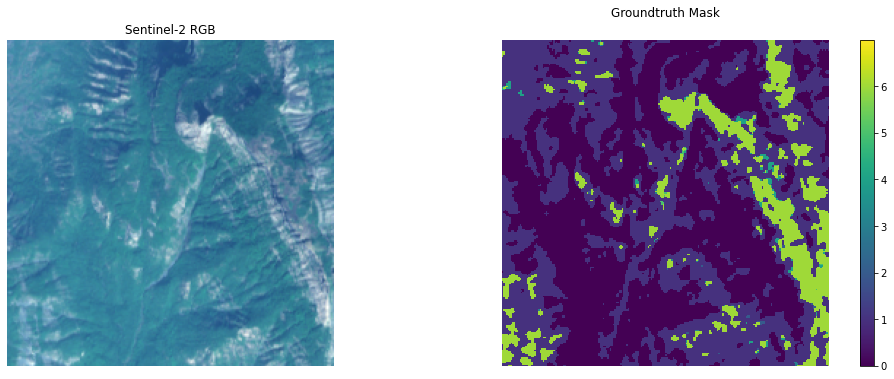

In [111]:
trainset.visualize_observation(16)

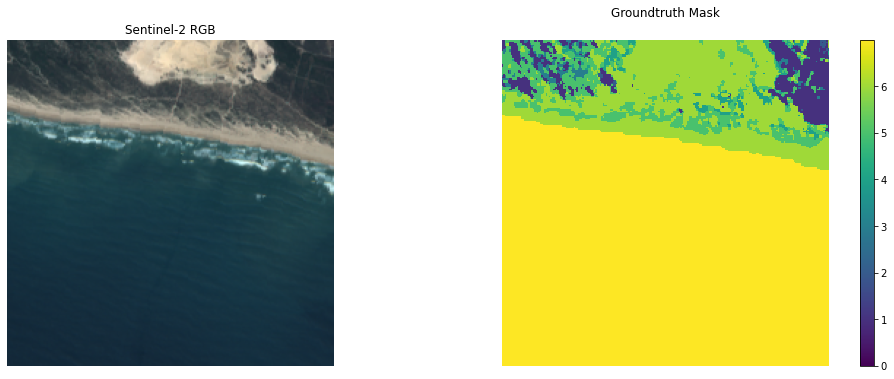

In [88]:
valset.visualize_observation(12)

<a id='model'></a>
## 4. Model Creation

In this lab, we will implement one of the most used neural networks for image segmentation: the U-NET. It is a Fully Convolutional Neural Network Model. This model was initially developed by Olaf Ronneberger, Phillip Fischer, and Thomas Brox in 2015 for medical image segmentation.

The architecture of U-NET is composed of two "paths":

- The first one is the contracting path, also called the encoder. It is used to capture the context of an image. It is in fact a group of convolution layers and max pooling layers allowing to create a feature map of an image and to reduce its size in order to reduce the number of network parameters.

- The second path is the symmetric expanding, also called decoder, to obtain the segmentation mask.

![UNet Model](pictures/unet-model.png)

We will start by defining the different building blocks of this network, namely the downsampling blocks, the upsampling blocks, the double convolution blocks and the output block. 

In [93]:
import torch.nn as nn
import torch.nn.functional as F

In [73]:
# Create the convolution block
class DoubleConv(nn.Module):
    """
    The DoubleConv object is composed of two successive blocks of convolutional layers, batch normalization and ReLU.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # Create a sequential module. 
        # nn.Sequential is a module inside which you can put other modules that will be applied one after the other. 
        self.double_conv = nn.Sequential(
            # First convolutional layer 
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),

            # First batchnormalization
            nn.BatchNorm2d(mid_channels),

            # First ReLU activation function
            nn.ReLU(inplace=True),

            # Second convolutional layer 
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),

            # Second batchnormalization
            nn.BatchNorm2d(out_channels),

            # Second ReLU activation function
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# Create the downsampling block
class Down(nn.Module):
    """
    The Down object is composed of a maxpooling layer followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Create a sequential module. 
        self.maxpool_conv = nn.Sequential(
            # 2D max pooling layer with a kernel size of 2 (meaning spatial dimension will be divided by two)
            nn.MaxPool2d(2),

            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


# Create the upsampling block
class Up(nn.Module):
    """
    The Up object is composed of an upsampling layer (bilinear interpolation) followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsampling layer with a scale factor of 2 (meaning spatial dimension will be multiplied by two)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
 
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
# Create the last convolution block, responsible of the pixel classification
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [74]:
class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)

        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outc(x)
        return x

In [75]:
model = UNet(13, 8)

<a id='train-val'></a>
## 5. Training and Validation

In [76]:
# First of all, let's verify if a GPU is available on our compute machine. If not, the cpu will be used instead.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Device used: {}'.format(device))

Device used: cpu


Our UNet model is now ready to be trained. In this section, we will walk through each of the steps in the training loop.

First, we need to define the criterion (the loss function) and the optimizer.

Optimizers define how the neural network weights should be updated. They take the model's parameters and learning rate as input arguments. In this lab, we will use the SGD (Stochastic Gradient Descent) optimizer. There are many other optimizers you can try like Adam, Adagrad, etc. (more info [here](https://pytorch.org/docs/stable/optim.html#algorithms))

In [77]:
# Define a learning rate
learning_rate = 0.01

# Initialise the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

The criterion is the loss you want to minimize. In this lab we will use the CrossEntropyLoss(), which is the combination of log_softmax() and NLLLoss(). You can read more about it [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [78]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.CrossEntropyLoss().to(device)

The steps of a training loop in Pytorch are almost always the same, no matter the application. They are made up of:
- Moving model and data to GPU (if available)
- Making a forward pass through the model
- Calculating the loss with regard to the groundtruth
- Erasing gradients using *optimizer.zero_grad()*
- Calculating the gradients by performing a backward pass using *loss.backward()*
- Updating the weights by taking the optimizer step using *optimizer.step()* 

The steps in a validation loop are similar, but you just need to make a forward pass and calculate the loss. Which means no gradient computation is needed. 

Before implementing this, let's go through 2 modes of the model object in Pytorch:

* Train Mode: Defined by model.train() , it tells your model that you are training the model. Layers like dropout, batchnorm etc. that behave differently in training and testing can behave accordingly.
* Evaluation mode: defined by model.eval() , it tells your model that you are testing the model.


In [ ]:
from sklearn.metrics import jaccard_score

def accuracy_score(y_true, y_pred):
    accuracy = 0
    height, width = y_true[0].shape[0], y_true[0].shape[1]
    for i in range(len(y_true)):
        accuracy += sum(np.array(y_pred[i].flatten().astype(int)) == np.array(y_true[i].flatten().astype(int))) / (height * width)
    return accuracy

def per_class_accuracy_score(y_true, y_pred):
    accuracy = 0
    height, width = y_true[0].shape[0], y_true[0].shape[1]
    for i in range(len(y_true)):
        accuracy += sum(np.array(y_pred[i].flatten().astype(int)) == np.array(y_true[i].flatten().astype(int))) / (height * width)
    return accuracy

def iou_score(y_true, y_pred):
    iou = 0
    height, width = y_true[0].shape[0], y_true[0].shape[1]
    for i in range(len(y_true)):
        iou += jaccard_score(np.array(y_true[i].flatten().astype(int)) == np.array(y_pred[i].flatten().astype(int)),  average='weighted')
    return iou

In [ ]:
# We will use the tqdm library to display the progress of our training. 
from tqdm.autonotebook import tqdm

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_loss = []
train_acc = []
train_iou = []

val_loss = []
val_acc = []
val_iou = []

# For every epoch 
for epoch in range(10):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        data = batch["img"].float().to(device)
        label = batch['mask'].type(torch.LongTensor).to(device)
        
        # Make a forward pass
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, label)
        
        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients 
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

    progress = tqdm(
        enumerate(test_loader), desc="val Loss: ",
        total=len(test_loader)
    )
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for i, batch in progress:
            # Transfer Data to GPU if available
            data = batch["img"].float().to(device)
            label = batch['mask'].type(torch.LongTensor).to(device)

            # Make a forward pass
            output = model(data)

            # Compute the loss
            val_loss = criterion(output, label)

            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(test_loader)
    
    # Save losses in list, so that we can visualise them later. 
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

# Save model
save_weights_path = "segmentation_model.pth"
torch.save(model.state_dict(), save_weights_path)

<a id='evaluation'></a>
## 6. Evaluation

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='val')
axes[0].set_tite('Losses')

axes[1].plot(train_acc, label='train')
axes[1].plot(val_acc, label='val')
axes[1].set_tite('Pixel accuracies')

In [ ]:
# load checkpoint and use it on validation data

<a id='exercice'></a>
## 7. Exercice

Now it's your turn to test what you learned during this lab